In [1]:
import wandb
from datetime import datetime

In [2]:
mask_model_ver = 132508
lr = 1e-3
batch_size = 16
wd = 1e-5
IMAGE_SIZE = 512
backbone='efficientdetv2_ds'
vertical_type = "axial"
train_portion = 0.5
milestones = [10,20,30,40]
model_name = "effdet"
epochs =100

checkpoint = 'axial_detection_effdet_134352-epoch-52.pth'

In [3]:
wandb_entity='longyi'
model_name = "effdet"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "backbone" : backbone,
    "image_size" : IMAGE_SIZE,
})
wandb.run.name = f'axial_detection_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_detection_effdet_101703'

In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold



# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_axial_images_jpeg95')
MASK_DIR = os.path.join(DATA_DIR, f'segmentation_axial_results_{mask_model_ver}')

In [6]:

total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [7]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv'))
bbox_df['UID_Slice'] = bbox_df['UID'] + '.' + bbox_df['axial_index'].astype('string')
bbox_df = bbox_df.set_index('UID_Slice')

bbox_df = bbox_df.loc[bbox_df.index.isin(total_boundary_df.index)]
print(len(bbox_df))
bbox_df.head()

7203


,UID,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID_Slice,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [8]:
boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(bbox_df.UID.unique())]
print(len(boundary_df))
boundary_df.head()

77339


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10051.0,1.2.826.0.1.3680043.10051,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,1.2.826.0.1.3680043.10051,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,1.2.826.0.1.3680043.10051,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,1.2.826.0.1.3680043.10051,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,1.2.826.0.1.3680043.10051,4,0,0.253906,0.0,0.0,512.0,512.0


Pick useful columns

In [9]:
train_df = pd.concat((bbox_df[['x','y','width','height']], boundary_df[['xmin','ymin','xmax','ymax','Slice', 'StudyInstanceUID']]), axis=1)
print(len(train_df))
train_df.head()

77339


,x,y,width,height,xmin,ymin,xmax,ymax,Slice,StudyInstanceUID
UID_Slice,,,,,,,,,,
1.2.826.0.1.3680043.10051.132,219.27715,216.71419,17.30440,20.38517,43.076729,0.0,436.923271,393.846542,132,1.2.826.0.1.3680043.10051
1.2.826.0.1.3680043.10051.133,221.56460,216.71419,17.87844,25.24362,36.076729,0.0,429.923271,393.846542,133,1.2.826.0.1.3680043.10051
1.2.826.0.1.3680043.10051.134,216.82151,221.62546,27.00959,26.37454,45.076729,0.0,438.923271,393.846542,134,1.2.826.0.1.3680043.10051
1.2.826.0.1.3680043.10051.135,214.49455,215.48637,27.92726,37.51363,41.076729,0.0,434.923271,393.846542,135,1.2.826.0.1.3680043.10051
1.2.826.0.1.3680043.10051.136,214.00000,215.48637,27.00000,43.51363,28.076729,0.0,421.923271,393.846542,136,1.2.826.0.1.3680043.10051


In [10]:
val_df = total_boundary_df[~total_boundary_df.StudyInstanceUID.isin(bbox_df.UID.unique())]
val_df = val_df.set_index('StudyInstanceUID')
print(len(val_df))
val_df.head()

631440


,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
StudyInstanceUID,,,,,,,
1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [11]:
label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
print(len(label_df))
label_df.head()

2019


,patient_overall,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


Only pick same size negative cases

In [12]:
neg_count = len(train_df[train_df['x'].isna()])
neg_count

70136

In [13]:
pos_count = len(train_df[~train_df['x'].isna()])
pos_count

7203

In [14]:
neg_df = train_df[train_df['x'].isna()]
pos_df = train_df[~train_df['x'].isna()]

In [15]:
neg_df.loc['1.2.826.0.1.3680043.17787.12']

x                                         NaN
y                                         NaN
width                                     NaN
height                                    NaN
xmin                                      0.0
ymin                                      0.0
xmax                                    512.0
ymax                                    512.0
Slice                                      12
StudyInstanceUID    1.2.826.0.1.3680043.17787
Name: 1.2.826.0.1.3680043.17787.12, dtype: object

In [16]:
def crop_image(img:Image, bbox, crop_box):
    """

    :param img:
    :param bbox: [left, top, right, bottom]
    :param crop_box:[left, top, right, bottom]
    :return:
    """
    left, top, right, bottom = crop_box
    img = img.crop(crop_box)
    bbox[0] -= left
    bbox[1] -= top
    bbox[2] -= left
    bbox[3] -= top

    return img, bbox

x                                      69.632
y                                    249.9159
width                                  57.344
height                               39.98988
xmin                                22.209607
ymin                               187.209607
xmax                               245.790393
ymax                               410.790393
Slice                                     297
StudyInstanceUID    1.2.826.0.1.3680043.11401
Name: 1.2.826.0.1.3680043.11401.297, dtype: object


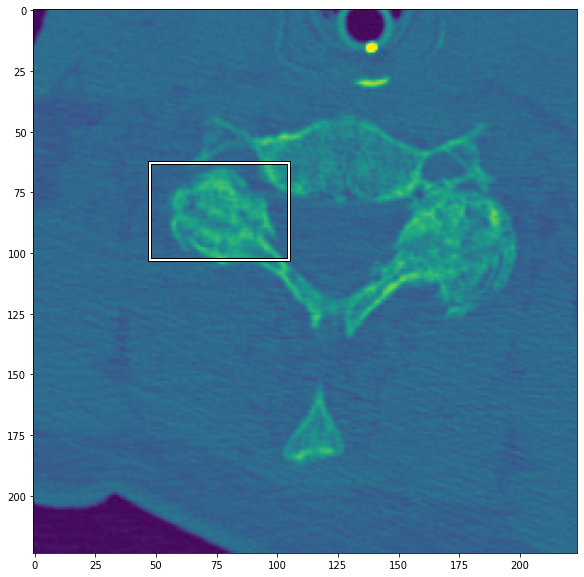

In [17]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return xmin_top_left, ymax_bottom_right, width, height


def draw_pascal_voc_bboxes(
        plot_ax,
        bbox,
        get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    x, y, width, height = get_rectangle_corners_fn(bbox)

    rect_1 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=4,
        edgecolor="black",
        fill=False,
    )
    rect_2 = patches.Rectangle(
        (x, y),
        width,
        height,
        linewidth=2,
        edgecolor="white",
        fill=False,
    )

    # Add the patch to the Axes
    plot_ax.add_patch(rect_1)
    plot_ax.add_patch(rect_2)


def show_image(
        image, bbox=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    draw_bboxes_fn(ax, bbox)

    plt.show()


s = pos_df.iloc[269]
print(s)
image = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{int(s.Slice)}.jpeg'))
bbox = list(s[['x', 'y','width','height']])
bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
crop_box = s[['xmin','ymin','xmax','ymax']]
image, bbox = crop_image(image, bbox, crop_box)
show_image(image, bbox)

## Dataset

In [18]:
class FractureDatasetAdaptor(Dataset):
    def __init__(self, images_dir_path, pos_df, neg_df):
        self.image_dir = images_dir_path
        self.pos_df = pos_df
        self.neg_df = neg_df

    def __len__(self) -> int:
        return len(self.pos_df) * 2

    def __getitem__(self, idx):
        
        is_pos = (idx % 2) == 0
        
        if is_pos:
            s = self.pos_df.iloc[idx // 2]
        else:
            rand_idx = np.random.randint(0, len(self.neg_df))
            s = self.neg_df.iloc[rand_idx]
        UID = s.StudyInstanceUID
        # print(s)
        slice = int(s.Slice)
        # print(UID, slice)
        r = Image.open(os.path.join(self.image_dir, UID, f"{max(0, slice-2)}.jpeg"))
        g = Image.open(os.path.join(self.image_dir, UID, f"{max(0, slice-1)}.jpeg"))
        b = Image.open(os.path.join(self.image_dir, UID, f"{slice}.jpeg"))
        img = Image.merge('RGB', (r, g, b))
        
        if pd.isna(s.x):
            pascal_bboxes = []
            class_labels = []
        else:
            pascal_bboxes = [[s.x, s.y, s.x + s.width, s.y + s.height]]
            class_labels = np.ones(1)

        crop_box = s[['xmin','ymin','xmax','ymax']].values
        return img, pascal_bboxes, class_labels, idx, crop_box

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes)
        print(class_labels)

da = FractureDatasetAdaptor(IMAGES_DIR, pos_df, neg_df)
da[0]

(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F6F19B128E0>,
 [[219.27715, 216.71419, 236.58155, 237.09936]],
 array([1.]),
 0,
 array([43.07672918324107, 0.0, 436.9232708167589, 393.84654163351786],
       dtype=object))

## Transform

{'bboxes': tensor([], size=(0, 4)), 'labels': tensor([]), 'image_id': tensor([269]), 'img_size': (512, 512), 'img_scale': tensor([1.])}
torch.Size([3, 512, 512])
tensor(-0.4980) tensor(0.9922)


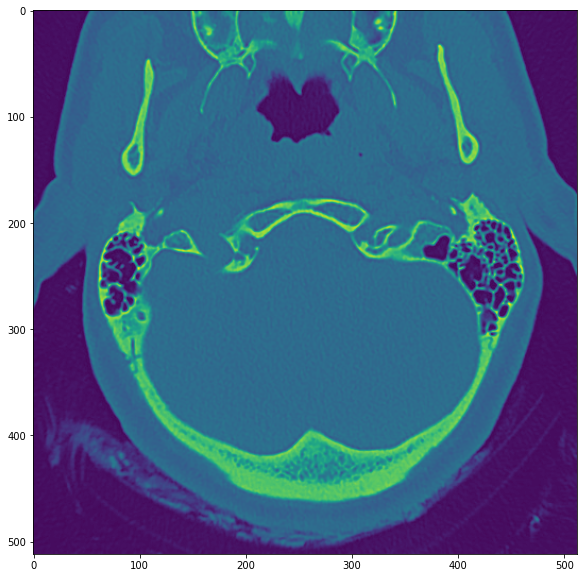

In [19]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.ShiftScaleRotate(p=0.5, rotate_limit=15),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )



class EfficientDetDataset(Dataset):
    def __init__(
            self, dataset_adaptor, transforms=None
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
            crop_box
        ) = self.ds[index]

        if len(pascal_bboxes) > 0:
            image, pascal_bboxes = crop_image(image, pascal_bboxes[0], crop_box)
            pascal_bboxes[0] = max(0, pascal_bboxes[0])
            pascal_bboxes[1] = max(0, pascal_bboxes[1])
            pascal_bboxes[2] = min(image.width, pascal_bboxes[2])
            pascal_bboxes[3] = min(image.height, pascal_bboxes[3])
            
            sample = {
                "image": np.array(image, dtype=np.float32),
                "bboxes": [pascal_bboxes],
                "labels": class_labels,
            }
            sample = self.transforms(**sample)
            sample["bboxes"] = np.array(sample["bboxes"])
            image = sample["image"]
            labels = sample["labels"]

            # print(sample)

            _, new_h, new_w = image.shape
            if len(sample["bboxes"]) > 0:
                sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
                                                :, [1, 0, 3, 2]
                                                ]  # convert to yxyx

                target = {
                    "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
                    "labels": torch.as_tensor(labels),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
            else:
                target = {
                    "bboxes": torch.zeros((0, 4)),
                    "labels": torch.tensor([]),
                    "image_id": torch.tensor([image_id]),
                    "img_size": (new_h, new_w),
                    "img_scale": torch.tensor([1.]),
                }
        else:
            image = image.crop(crop_box)   
            image = self.transforms(image=np.array(image, dtype=np.float32), bboxes=[], labels=[])["image"]
            _, new_h, new_w = image.shape
            target = {
                "bboxes": torch.zeros((0, 4)),
                "labels": torch.tensor([]),
                "image_id": torch.tensor([image_id]),
                "img_size": (new_h, new_w),
                "img_scale": torch.tensor([1.]),
            }
        
        

        return image, target, image_id

    def __len__(self):
        return len(self.ds)


train_dataset = EfficientDetDataset(da, transforms=get_train_transforms(IMAGE_SIZE))
img, ann, idx = train_dataset[269]
print(ann)
print(img.shape)
print(img.min(), img.max())
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img[2, :, :])

if len(ann['bboxes']) > 0:
    draw_pascal_voc_bboxes(ax, ann['bboxes'][0].cpu().numpy()[[1, 0, 3, 2]])


In [20]:
def collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images)
    images = images.float()

    boxes = [target["bboxes"].float() for target in targets]
    labels = [target["labels"].float() for target in targets]
    img_size = torch.tensor([target["img_size"] for target in targets]).float()
    img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

    annotations = {
        "bbox": boxes,
        "cls": labels,
        "img_size": img_size,
        "img_scale": img_scale,
    }

    return images, annotations, targets, image_ids

In [21]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
    num_workers=min(os.cpu_count(), 16),
    collate_fn=collate_fn,
)

## Model

In [22]:
# from effdet.config.model_config import efficientdet_model_param_dict
# list(efficientdet_model_param_dict.keys())

In [23]:
from effdet import create_model

def get_det_model(image_size, checkpoint=None):
    if checkpoint is None:

        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        model = model.to(device)
        return model
    else:
        model = create_model(backbone , bench_task='train' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
        state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint), map_location=torch.device(device))
        model.load_state_dict(state["model"])
        model = model.to(device)
        return model

model = get_det_model(IMAGE_SIZE, checkpoint)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

26374778


In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

## Train one epoch

In [25]:
def train_one_epoch(e, model, dataloader, val_model):
    model.train()
    train_iter = tqdm(dataloader)
    loss_list = []
    epoch_iteration = len(dataloader)

    for i, (images, anns, _, _) in enumerate(train_iter):
        images = images.to(device)
        anns = {
            'bbox' : [tensor.to(device) for tensor in anns['bbox']],
            'cls' : [tensor.to(device) for tensor in anns['cls']],
            'img_size' : anns['img_size'].to(device),
            'img_scale' : anns['img_scale'].to(device)
        }

        with torch.cuda.amp.autocast(device == 'cuda'):
            losses = model(images, anns)
            loss, class_loss, box_loss = losses['loss'], losses['class_loss'], losses['box_loss']

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step(e + i / epoch_iteration)

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {class_loss.item():.4f} b {box_loss.item():.4f}")

        loss_list.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'train_class_loss': class_loss.item(),
                'train_box_loss': box_loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })
            
        
        if (i + e * epoch_iteration) % 100 == 0:
            # val_model = DetBenchPredict(model.model).to(device)
            val_model.eval()
            val_index = (e * epoch_iteration + i) // 100
            prediction = evaluate(e, val_model, val_index=val_index)
            
            model.train()

    return np.mean(loss_list)

In [26]:
val_UIDs = list(val_df.index.unique())
len(val_UIDs)

1778

torch.Size([1, 512, 512]) (4,) torch.Size([1, 256, 256])
tensor(0.) tensor(0.5255)
[ 65.07672918   0.         458.92327082 393.84654163]


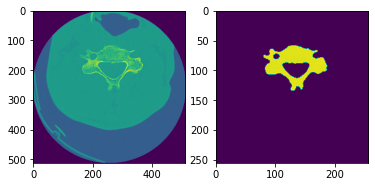

In [27]:
class ValidationDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, mask_path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.mask_path = mask_path
        self.transforms = transforms

        self.len = len(self.df)

    def __getitem__(self, i):

        try:
            s = self.df.iloc[i]
            UID = s.name
            img = Image.open(os.path.join(self.path, UID, f'{int(s.Slice)}.jpeg'))

            mask = Image.open(os.path.join(self.mask_path, UID, f'{int(s.Slice)}.png'))
            
            if self.transforms is not None:
                img, mask = self.transforms(img, mask)
        except Exception as ex:
            print(ex)
            return None, None

        return img, s.pixel_spacing, s.Slice == s.Start, s[['xmin','ymin','xmax','ymax']].values, mask

    def __len__(self):
        return self.len

class ValidationTransform(nn.Module):
    def __init__(self, image_size=512):
        super().__init__()

        self.image_size = image_size

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(0.5, 0.5),
        ])
        
        self.mask_transform = T.Compose([
            T.ToTensor(),
        ])

    def forward(self, x, mask):
        x = self.transform(x)
        mask = self.mask_transform(mask)
        return x, mask
    
val_tf = ValidationTransform(IMAGE_SIZE)

UID = '1.2.826.0.1.3680043.10001'
evaluate_df = val_df.loc[UID].sort_values('Slice')
# evaluate_df.iloc[0]
# print(evaluate_df)
val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR, transforms=val_tf)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

# iter_d = iter(val_loader)
# next(iter_d)
# next(iter_d)
# next(iter_d)
img, pixel_spacing, is_end, bbox, mask = val_ds[138]
print(img.shape, bbox.shape, mask.shape)
print(mask.min(), mask.max())
print(bbox)
_, axs = plt.subplots(1, 2)
axs[0].imshow(img[0, :, :])
axs[1].imshow(mask[0, :, :])

In [28]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

In [29]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

In [30]:
val_df.loc['1.2.826.0.1.3680043.10001'].sort_values('Slice')

,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
StudyInstanceUID,,,,,,,
1.2.826.0.1.3680043.10001,0,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,1,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,2,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,3,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,4,0,0.253906,0.000000,0.0,512.0,512.000000
...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.10001,263,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,264,0,0.253906,0.000000,0.0,512.0,512.000000
1.2.826.0.1.3680043.10001,265,0,0.253906,0.000000,0.0,512.0,512.000000


In [31]:
from effdet import DetBenchPredict

def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def predict_det(x, model):
    
    bboxes = model(x) # N x 1 x 6
    
    return bboxes[:, 0, :]

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

def get_class_score(scores, class_list, eps=1e-2):
    result = scores.new_zeros((scores.shape[0], 8)) + eps
    class_list = torch.nan_to_num(class_list).long()
    result[torch.arange(scores.shape[0]), class_list] = scores
    
    return result

def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()


table_columns=['UID', 'loss', 'Predictions','Labels']
evaluate_table = wandb.Table(data=[], columns=table_columns)

def log_prediction(UID, prediction):
    # log
    
    
    label = label_df.loc[UID].values
    loss = cal_loss(prediction, label)
   
    # my_data = [UID, loss, prediction, label]
    
    # evaluate_table.add_data(*my_data)
    
    wandb.run.log({
        # 'evaluate_table' : evaluate_table
        'eval_sample_UID' : int(UID.split('.')[-1]),
        'eval_sample_loss' : loss,
    })
    


def evaluate(e, det_model, UID=None, val_index=None):
    
    if UID is None:
        UID = val_UIDs[val_index]
    
    with torch.no_grad():
        evaluate_df = val_df.loc[UID].sort_values('Slice')
        # print(evaluate_df)
        val_ds = ValidationDataSet(evaluate_df, IMAGES_DIR, MASK_DIR,val_tf)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=min(batch_size, 16))

        predictions = []
        x0 = val_ds[0][0]
        x1 = val_ds[1][0]
        x0, x1 = x0.to(device), x1.to(device)
        prev2 = torch.stack((x0, x1))

        for x, pixel_spacings, is_starts, axial_boundary, seg_result in val_loader:
            x = x.to(device)
            

            # (N+2), 1, 512, 512
            x = torch.cat((prev2, x), dim=0)

            r = x[:-2, :, :, :]
            g = x[1:-1, :, :, :]
            b = x[2:, :, :, :]

            start_indices = torch.argwhere(is_starts)
            r[start_indices, :, :, :] = b[start_indices, :, :, :]
            g[start_indices, :, :, :] = b[start_indices, :, :, :]

            prev2 = b[-2:, :, :, :]

            x = torch.cat((r, g, b), dim=1)

            batch_probs = x.new_zeros((x.shape[0], 8)) + 1e-2

            seg_result = seg_result.to(device)
            # seg_areas = seg_result.count_nonzero(dim=[1, 2, 3]) / (256 * 256)

            # active_indices = torch.argwhere(seg_areas > 0.001)
            active_indices = seg_result.nonzero()[:, 0].unique()

            if active_indices.numel() == 0:
                predictions.append(batch_probs.cpu())
                continue

            axial_boundary, seg_result = axial_boundary.to(device), seg_result.to(device)
            active_indices = active_indices.reshape(-1)

            if active_indices.numel() != batch_size:
                x = x[active_indices, :, :, :]
                seg_result = seg_result[active_indices, :, :, :]
                pixel_spacings = pixel_spacings[active_indices]
                axial_boundary = axial_boundary[active_indices]
                


            # axial_boundary = get_axial_boundary(seg_result, pixel_spacings, seg_img_size=256)  # N x 4, 512 scale

            x = crop_resize_images(x, axial_boundary) # N x 3 x 512 x 512 croped


            # for det_model in det_models:
            det_result = predict_det(x, det_model)
            bboxes, scores = get_original_bbox(det_result[:, :4], axial_boundary), det_result[:, 4]
            class_list = get_bbox_class_list(seg_result[:, 0, :, :], bboxes / 2)
            probs = get_class_score(scores, class_list) # N x 7

            batch_probs[active_indices, :] = probs
            # print(probs)
            predictions.append(batch_probs.cpu())

        predictions = torch.concat(predictions)
      
        # predictions[:, 0] = torch.amax(predictions, dim=1)
        prediction = predictions.amax(dim=0)
        prediction[0] = prediction[1:].amax()
        # print(predictions)
        # return predictions
        
        
        if wandb.run is not None:
            log_prediction(UID, prediction.numpy())
        
        
        return prediction

val_model = DetBenchPredict(model.model).to(device)
val_model = val_model.eval()
# prediction = evaluate(0, val_model)
# prediction

In [32]:
def save_state(epoch):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "epoch": epoch,
    }
    torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))


In [33]:
epoch = 0


In [ ]:
for e in range(12):

    train_loss = train_one_epoch(epoch, model, train_loader, val_model)

    # with torch.no_grad():
    #     evaluate(epoch, model, val_loader)


    epoch += 1
    scheduler.step()
    
    # if epoch % 10 == 0:
    #     save_state(epoch)

t 6 loss 0.1409 c 0.0907 b 0.0010:  56%|█████▌    | 500/900 [03:58<02:38,  2.52it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 239, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/root/miniconda3/lib/python3.8/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/root/miniconda3/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 359, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 239, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/root/miniconda3/lib/python3.8/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/root/miniconda3/lib/python3.8/multiprocessing/reduction.py", line 198, in DupFd
    return resource_sharer.DupFd(fd)
  File "/root/miniconda3/lib/pyth

In [35]:
save_state(epoch)